In [ ]:
%%capture

!pip install drawdata

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drawdata import ScatterWidget

### ***OBTAINING DATA***

`drawdata` offers an interactive way to build your own `pandas` dataset. Can you make your data ***linearly separable***?

In [2]:
widget = ScatterWidget()
widget

ScatterWidget()

In [3]:
data = widget.data_as_pandas
data.head(2)

,x,y,color,label
0,99.650602,426.206748,#1f77b4,a
1,114.974738,424.223584,#1f77b4,a


### ***DATA PREPROCESSING***

Do you see any issues with our current data? Here, we'll take the following preprocessing steps:

1. Remove the `color` column
2. Label encode `label` column
3. Randomize dataset
4. Normalize dataset


In [4]:
unique_labels = sorted(data['label'].unique()) # Extract unique labels and sort them
label_map = {label: idx for idx, label in enumerate(unique_labels)} # Map each unique label to an integer

# Apply mapping to the dataset
data['label'] = data['label'].map(label_map)

# Shuffle data and prepare features/labels
data = data.sample(frac=1).drop('color', axis=1)

X = data[['x', 'y']].to_numpy()
y = data[['label']].to_numpy()

print("Label Mapping:", label_map)
data.head(2)

Label Mapping: {'a': 0, 'd': 1}


,x,y,label
53,112.424845,187.582233,0
172,634.054672,169.677451,1


In [6]:
def normalize_data(X):
  """
  Compute the mean and standard deviation of the
  input data and normalize the data.
  """
  mean = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  X_normalized = (X - mean) / std
  return X_normalized

X = normalize_data(X)

### ***ACTIVATION FUNCTIONS***

What is an activation function? Why are they useful? Can you recreate `relu` using `np.maximum`?

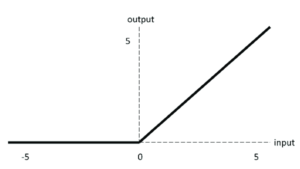

In [7]:
def relu(x):
  return np.maximum(0, x)

def relu_deriv(x):
  return np.where(x > 0, 1, 0)

def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### ***NN ARCHITECTURE***

Our network will have:

- 2 inputs (`x`, `y`)
- 1 hidden layer
- 2 outputs (predicted color)

To do this, we must `init_params`, and `train` them by repeatedly passing them through the `forward_pass` and updating those parameters via gradient descent in the `backward_pass`. We do this over a specified number of `iterations`.

In [8]:
def init_params(input_size, hidden_size, output_size):
  """
  Initialize weights. Input nodes go to hidden nodes,
  hidden nodes go to output nodes.
  """

  W1 = np.random.uniform(-0.01, 0.01, size=(input_size, hidden_size))
  b1 = np.zeros(hidden_size)

  W2 = np.random.uniform(-0.01, 0.01, size=(hidden_size, output_size))
  b2 = np.zeros(output_size)

  return W1, b1, W2, b2

def forward_pass(X, W1, b1, W2, b2):
  """
  Move weights forward through network.
  This phase is responsible for predictions.
  """

  Z1 = np.dot(X, W1) + b1
  A1 = relu(Z1)

  Z2 = np.dot(A1, W2) + b2
  A2 = softmax(Z2)

  return A2, Z1, A1

def backward_pass(X, y, Z1, A1, A2, W1, W2):
  """
  Move weights backward through network.
  This phase is responsible for updating weights.
  """

  one_hot_y = np.eye(A2.shape[1])[y.flatten()]
  dZ2 = A2 - one_hot_y
  dW2 = np.dot(A1.T, dZ2)
  db2 = np.sum(dZ2, axis=0)

  da1 = np.dot(dZ2, W2.T)
  dZ1 = da1 * relu_deriv(Z1)
  dW1 = np.dot(X.T, dZ1)
  db1 = np.sum(dZ1, axis=0)

  return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
  W1 -= lr * dW1
  b1 -= lr * db1

  W2 -= lr * dW2
  b2 -= lr * db2

  return W1, b1, W2, b2

In [13]:
def train(X, y, W1, b1, W2, b2, lr, epochs):
  """
  Train weights over a specified number of epochs.

  Through each iteration, the weights:

  - Go through forward phase (and are outputted as predictions)
  - Go through backward phase (and are updated to hopefully correct errors)

  Then, we return the updated weights.
  """

  history = []
  num_samples = X.shape[0]
  num_classes = len(np.unique(y))

  # Convert y to one-hot encoding
  y_one_hot = np.eye(num_classes)[y.flatten()]

  for epoch in range(epochs):
    # Forward pass
    A2, Z1, A1 = forward_pass(X, W1, b1, W2, b2)

    # Compute cross-entropy loss
    loss = -np.mean(np.sum(y_one_hot * np.log(A2 + 1e-9), axis=1))  # Add small value to prevent log(0)
    history.append(loss)

    # Backward pass (using cross-entropy + softmax gradient)
    dW1, db1, dW2, db2 = backward_pass(X, y, Z1, A1, A2, W1, W2)
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

    if epoch % 10 == 0:
      print(f"Epoch {epoch}, Loss: {loss}")

  return W1, b1, W2, b2, history

### ***TRAIN NETWORK***

In [11]:
INPUT_SIZE = 2
OUTPUT_SIZE = len(np.unique(y))

hidden_size = 20
lr = 0.01
iterations = 30

In [14]:
# Initialize parameters
W1, b1, W2, b2 = init_params(INPUT_SIZE, hidden_size, OUTPUT_SIZE)

# Train the model
W1, b1, W2, b2, loss_history = train(X, y, W1, b1, W2, b2, lr, iterations)

Epoch 0, Loss: 0.6932073101665799
Epoch 10, Loss: 0.005703162914236994
Epoch 20, Loss: 0.001798622887513214


### ***PREDICTIONS & PLOTTING***

In [18]:
def predict(X, W1, b1, W2, b2):
  A2, _, _ = forward_pass(X, W1, b1, W2, b2)
  predictions = np.argmax(A2, axis=1)  # Get class with highest probability

  # Map predictions back to original labels
  reverse_label_map = {0: "a", 1: "b", 2: "c", 3: "d"}
  predicted_labels = np.vectorize(reverse_label_map.get)(predictions)

  return predicted_labels

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def masterplot(epochs, history, X, y, preds):
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # Loss History Plot (Left)
  axes[0].plot(range(epochs), history, label='Loss', marker='o', markersize=6, color='b', linewidth=2, linestyle='-', alpha=0.7)
  axes[0].set_title('Loss History', fontsize=16, weight='bold', color='darkblue')
  axes[0].set_xlabel('Iteration', fontsize=14, weight='bold', color='darkblue')
  axes[0].set_ylabel('Loss', fontsize=14, weight='bold', color='darkblue')
  axes[0].grid(True, linestyle='--', alpha=0.5)
  axes[0].legend(fontsize=12)

  # Decision Boundary Plot (Right)
  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))

  grid_points = np.c_[xx.ravel(), yy.ravel()]
  Z = preds(grid_points)
  Z = np.vectorize({"a": 0, "b": 1, "c": 2, "d": 3}.get)(Z)  # Convert to numeric
  Z = Z.reshape(xx.shape)

  # Contour plot for decision boundary
  axes[1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
  scatter = axes[1].scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)

  # Legend
  handles, labels = scatter.legend_elements()
  axes[1].legend(handles, ["a", "b", "c", "d"], title="Classes")
  axes[1].set_title("Decision Boundary", fontsize=16, weight='bold')

  plt.tight_layout()
  plt.show()

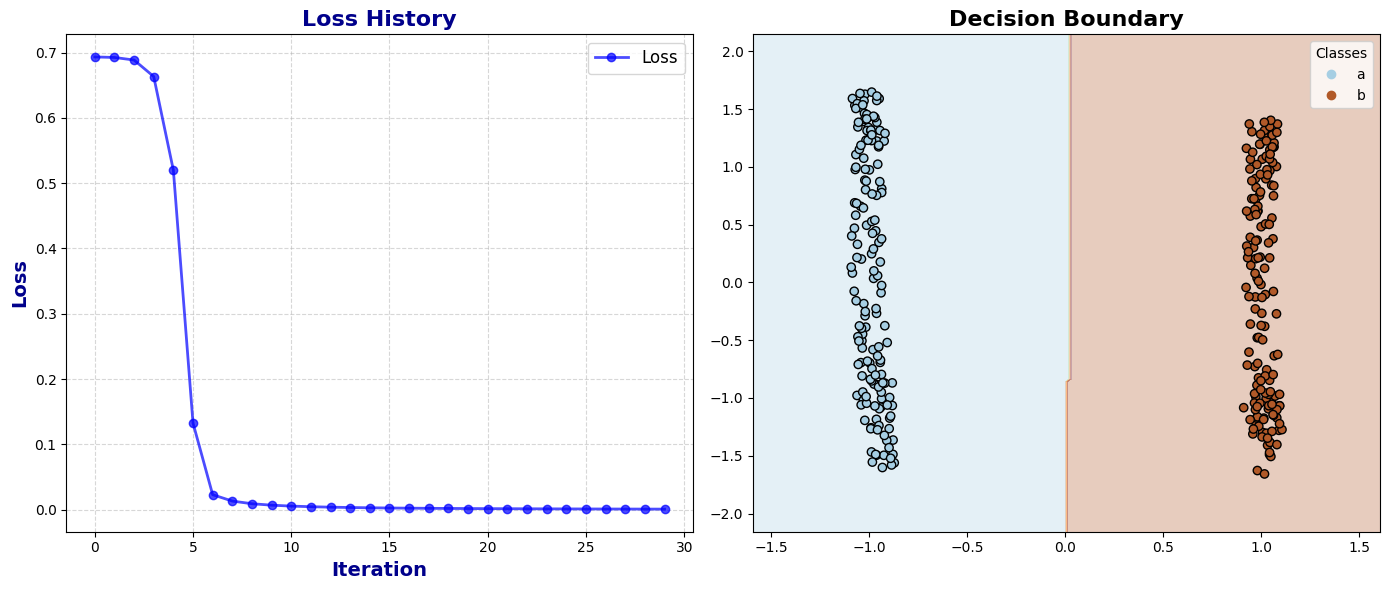

In [20]:
masterplot(iterations, loss_history, X, y, lambda X_new: predict(X_new, W1, b1, W2, b2))

### ***DIY - TRAIN A NEURAL NETWORK***

Now we'll hand things off to you. Can you show us a non-separable data example?

In [22]:
widget2 = ScatterWidget()
widget2

ScatterWidget()

### ***DATA PREPROCESSING***

Same as before. Here, we

- Label encode our response variable (`label`)
- Drop unneeded columns (`color`)
- Randomize data
- Split into features and response (`X` and `y`)
- Normalize `X`

In [23]:
data2 = widget2.data_as_pandas
unique_labels = sorted(data2['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
data2['label'] = data2['label'].map(label_map)
data2 = data2.sample(frac=1).drop('color', axis=1)
X2 = data2[['x', 'y']].to_numpy()
y2 = data2[['label']].to_numpy()
X2 = normalize_data(X2)
print("Label Mapping:", label_map)

Label Mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3}


### ***TRAIN/TEST SPLIT***

Unlike the previous example, here, we will do a `train`/`test` split. We don't
want our model to cheat.

We will allocate `80%` of our data into training, and the remaining `20%` will
be used for testing purposes.

In [24]:
train_size = int(len(X2) * 0.80)

X_train2, y_train2 = X2[:train_size,], y2[:train_size,]
X_test2, y_test2 = X2[train_size:,], y2[train_size:,]

In [26]:
OUTPUT_SIZE = len(np.unique(y2))

hidden_size = 20
lr = 0.01
iterations = 30

W3, b3, W4, b4 = init_params(INPUT_SIZE, hidden_size, OUTPUT_SIZE)
W3, b3, W4, b4, loss_history = train(X_train2, y_train2, W3, b3, W4, b4, lr, iterations)

Epoch 0, Loss: 1.3862815824706347
Epoch 10, Loss: 1.2300242776721222
Epoch 20, Loss: 1.2463400017907766


### ***PREDICTIONS & PLOTTING***

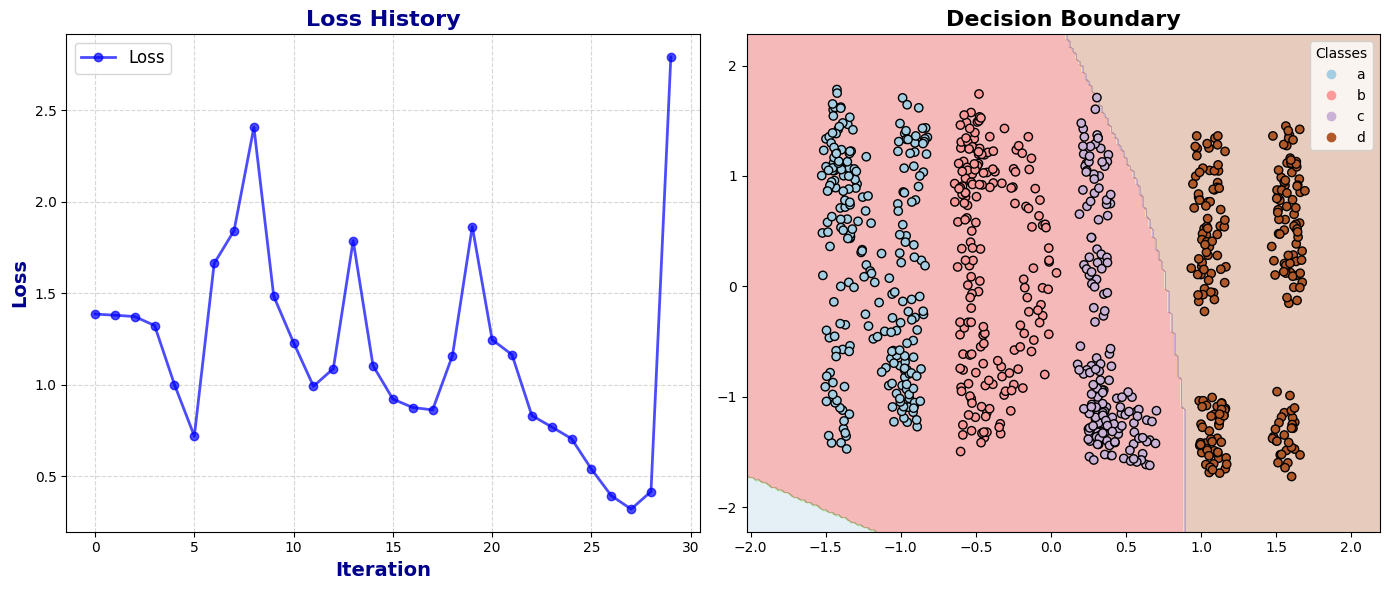

In [27]:
masterplot(iterations, loss_history, X2, y2, lambda X_new: predict(X_new, W3, b3, W4, b4))

### ***HOW ACCURATE WERE WE???***

In [31]:
def accuracy(y_true, y_pred):
  y_true = np.round(y_true).astype(int)

  label_map = {0: "a", 1: "b", 2: "c", 3: "d"}
  y_true = np.vectorize(label_map.get)(y_true)

  accuracy = np.sum(y_true == y_pred) / len(y_true)

  return f"{np.round(accuracy, 2)}% 😎"

accuracy(y_test2, predict(X_test2, W3, b3, W4, b4))

'31.25% 😎'